In [1]:
import os
import sys

In [2]:
os.chdir('/home/au643300/DataHandling/')
sys.path.append('/home/au643300/DataHandling/')

In [3]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, as_completed
import glob
from src.data.tonetCDF import to_netcdf
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from src.interim import read_valdata
import numpy as np
import importlib

In [4]:
sns.set_theme()

In [5]:
cluster=SLURMCluster(cores=8,
                     memory="30GiB",
                     queue='q64',
                     walltime='0-01:00:00',
                     local_directory='/scratch/$SLURM_JOB_ID',
                     interface='ib0',
                     scheduler_options={'interface':'ib0'},
                     extra=['--resources mem=15',"--lifetime", "55m", "--lifetime-stagger", "4m"]
                    )
                    

In [6]:
client=Client(cluster)

In [7]:
cluster.adapt(minimum=1,maximum=4)

In [8]:
client

Client Scheduler: tcp://10.100.8.23:42215 Dashboard: http://10.100.8.23:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
batches=5

In [10]:
mean=xr.open_mfdataset('data/interim/stats_1snap.nc',parallel=True)
mean=mean.sortby("time")
mean

<xarray.Dataset>
Dimensions:           (time: 1, x: 256, y_plus: 201, z: 256)
Coordinates:
  * x                 (x) float64 0.0 0.04688 0.09375 ... 11.86 11.91 11.95
  * y_plus            (y_plus) float64 790.0 790.0 789.8 ... 0.1949 0.04873 0.0
  * z                 (z) float64 -3.0 -2.977 -2.953 -2.93 ... 2.93 2.953 2.977
  * time              (time) float64 2.632e+03
Data variables: (12/14)
    u_plusmean        (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    u_plusRMS         (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    v_plusmean        (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    v_plusRMS         (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    w_plusmean        (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    w_plusRMS         (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    ...                ...
    pr0.71_plusmean   (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.71_plusRMS    (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.2_plusmean    (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.2_plusRMS     (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.025_plusmean  (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>
    pr0.025_plusRMS   (time, y_plus) float64 dask.array<chunksize=(1, 201), meta=np.ndarray>

In [11]:
mean=mean.groupby_bins("time",batches).mean()
mean

<xarray.Dataset>
Dimensions:           (time_bins: 5, x: 256, y_plus: 201, z: 256)
Coordinates:
  * time_bins         (time_bins) object (2629.368, 2630.421] ... (2633.579, ...
  * x                 (x) float64 0.0 0.04688 0.09375 ... 11.86 11.91 11.95
  * y_plus            (y_plus) float64 790.0 790.0 789.8 ... 0.1949 0.04873 0.0
  * z                 (z) float64 -3.0 -2.977 -2.953 -2.93 ... 2.93 2.953 2.977
Data variables: (12/14)
    u_plusmean        (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    u_plusRMS         (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    v_plusmean        (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    v_plusRMS         (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    w_plusmean        (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    w_plusRMS         (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    ...                ...
    pr0.71_plusmean   (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    pr0.71_plusRMS    (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    pr0.2_plusmean    (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    pr0.2_plusRMS     (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    pr0.025_plusmean  (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>
    pr0.025_plusRMS   (time_bins, y_plus) float64 dask.array<chunksize=(5, 201), meta=np.ndarray>

# Time for Plots

first for u

In [12]:
val_u=read_valdata.get_valdata('u')
val_u

,y+,u_plusmean,u_plusRMS
0,0.110599,0.111710,0.044552
1,0.335591,0.338835,0.134803
2,0.568392,0.573689,0.227932
3,0.809442,0.816661,0.324119
4,1.059180,1.068110,0.423493
...,...,...,...
235,385.400000,20.388000,0.811675
236,387.534000,20.389900,0.810588
237,389.667000,20.391200,0.809762
238,391.800000,20.392100,0.809203


Persisting the mean dataset to allow faster computation

In [13]:
mean=mean.persist()
mean

Here $<u_+>$ and $<u_{rms}>$ are plotted

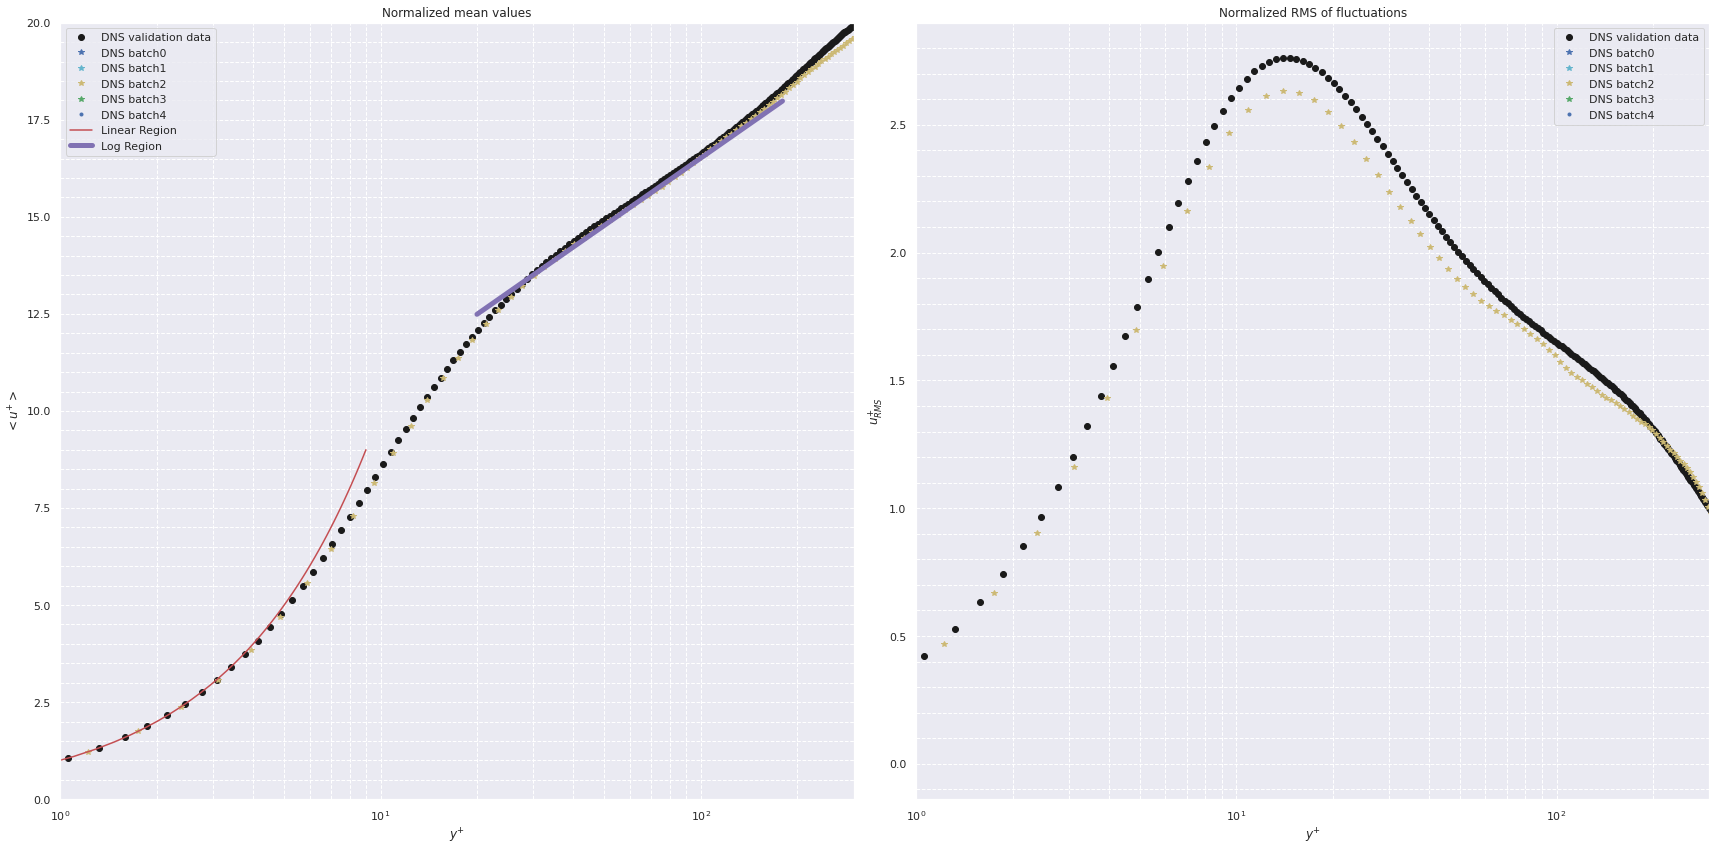

In [15]:
linerRegion = np.linspace(0,9)
logRegion = 1/0.4*np.log(np.linspace(20, 180))+5
figScale=2
fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(12*figScale,6*figScale))
ax1.plot('y+', 'u_plusmean','ok',data=val_u, label='DNS validation data')
colorList = ['*b', '*c', '*y', '*g','.b', '.c', '.y', '.g','vb', 'vc', 'vy', 'vg','<b', '<c', '<y', '<g']*30
#Plotting the batches in mean for U
for i in range(len(mean.time_bins)):
    ax1.plot(mean.y_plus, mean.u_plusmean.isel(time_bins=i), colorList[i], label='DNS batch'+str(i))
    
ax1.plot(linerRegion, linerRegion, 'r', label='Linear Region')
ax1.plot(np.linspace(20,180), logRegion, 'm', linewidth=5, label='Log Region')  

ax1.set_title('Normalized mean values')
ax1.set_xscale('log')
ax1.set_xlabel('$y^{+}$')
ax1.set_ylabel('$<u^{+}>$')
ax1.set_xlim(1,300)
ax1.set_ylim(0,20)
ax1.minorticks_on()
ax1.grid(True,which="both", linestyle='--')
ax1.legend()

#Now for <u_rms>

ax2.plot('y+', 'u_plusRMS','ok',data=val_u, label='DNS validation data')
ax2.set_title('Normalized RMS of fluctuations')
for i in range(len(mean.time_bins)):
        ax2.plot(mean.y_plus, mean.u_plusRMS.isel(time_bins=i), colorList[i], label='DNS batch'+str(i))

ax2.set_xscale('log')
ax2.set_xlabel('$y^{+}$')
ax2.set_ylabel("$u^{+}_{RMS}$")
ax2.set_xlim(1,300)
ax2.minorticks_on()
ax2.grid(True,which="both", linestyle='--')
ax2.legend()
plt.tight_layout()

Now plotting the Prandel numbers

In [16]:
a=read_valdata.get_valdata('pr1')
b=read_valdata.get_valdata('pr71')
c=read_valdata.get_valdata('pr0025')

val_pr=[a,b,c]
val_pr=val_pr[0].join(val_pr[1:])
val_pr

,pr1_y+,pr1_plusmean,pr1_plusRMS,pr0.71_y+,pr0.71_plusmean,pr0.71_plusRMS,pr0.025_y+,pr0.025_plusmean,pr0.025_plusRMS
0,0.110599,0.110599,0.045825,0.110599,0.078525,0.032625,0.147713,0.003701,0.000973
1,0.335591,0.335589,0.139052,0.335591,0.238269,0.098998,0.452484,0.011336,0.002981
2,0.568392,0.568367,0.235510,0.568392,0.403545,0.167677,0.778054,0.019492,0.005127
3,0.809442,0.809331,0.335331,0.809442,0.574646,0.238770,1.128720,0.028276,0.007438
4,1.059180,1.058850,0.438598,1.059180,0.751847,0.312359,1.508910,0.037799,0.009944
...,...,...,...,...,...,...,...,...,...
235,385.400000,20.056500,0.857072,385.400000,17.216400,0.847261,NaN,NaN,NaN
236,387.534000,20.058100,0.855997,387.534000,17.218100,0.846372,NaN,NaN,NaN
237,389.667000,20.059200,0.855195,389.667000,17.219400,0.845693,NaN,NaN,NaN
238,391.800000,20.060000,0.854665,391.800000,17.220300,0.845236,NaN,NaN,NaN


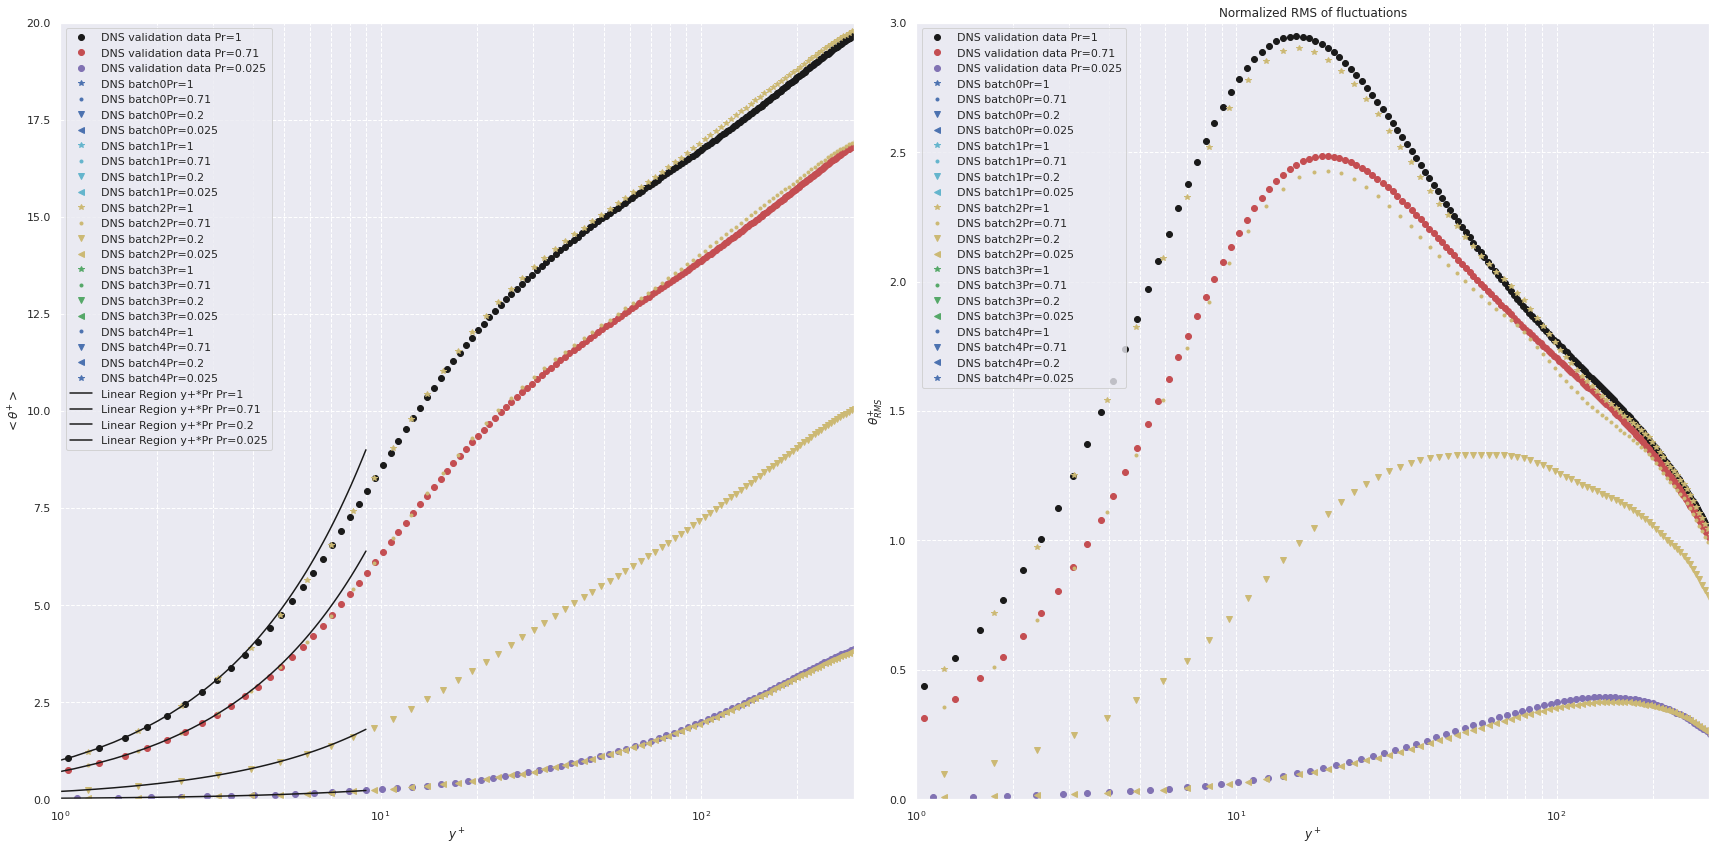

In [17]:
linerRegion = np.linspace(0,9)
logRegion = 1/0.43*np.log(np.linspace(20, 180))+3
figScale=2

fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(12*figScale,6*figScale))
ax1.plot('pr1_y+', 'pr1_plusmean','ok',data=val_pr, label='DNS validation data Pr=1')
ax1.plot('pr0.71_y+', 'pr0.71_plusmean','or',data=val_pr, label='DNS validation data Pr=0.71')
ax1.plot('pr0.025_y+', 'pr0.025_plusmean','om',data=val_pr, label='DNS validation data Pr=0.025')
colorList = ['*b', '*c', '*y', '*g','.b', '.c', '.y', '.g','vb', 'vc', 'vy', 'vg','<b', '<c', '<y', '<g']*30

#Plotting the batches in mean for the different Pr
pr_list=['pr1','pr0.71','pr0.2','pr0.025']
j=0
for i in range(len(mean.time_bins)):
    for Pr in pr_list:
        ax1.plot(mean.y_plus, mean[Pr+'_plusmean'].isel(time_bins=i), colorList[j*4+i], label='DNS batch'+str(i) + 'Pr='+Pr[2:])
        j=j+1

dualColor=['k','r']     
j=0
for Pr in pr_list:
    ax1.plot(linerRegion, linerRegion*float(Pr[2:]), dualColor[i%2], label='Linear Region y+*Pr '+ 'Pr='+Pr[2:])
    j=j+1
    
    

ax1.set_xscale('log')
ax1.set_xlabel('$y^+$')
ax1.set_ylabel(r'$<\theta^{+}>$')
ax1.set_xlim(1,300)
ax1.set_ylim(0,20)
ax1.grid(True,which="both", linestyle='--')
ax1.legend()

#Now for <Pr_rms>


ax2.plot('pr1_y+', 'pr1_plusRMS','ok',data=val_pr, label='DNS validation data Pr=1')
ax2.plot('pr0.71_y+', 'pr0.71_plusRMS','or',data=val_pr, label='DNS validation data Pr=0.71')
ax2.plot('pr0.025_y+', 'pr0.025_plusRMS','om',data=val_pr, label='DNS validation data Pr=0.025')
ax2.set_title('Normalized RMS of fluctuations')
j=0
for i in range(len(mean.time_bins)):
    for Pr in pr_list:
        ax2.plot(mean.y_plus, mean[Pr+'_plusRMS'].isel(time_bins=i), colorList[j*4+i], label='DNS batch'+str(i) + 'Pr='+Pr[2:])
        j=j+1

ax2.set_xscale('log')
ax2.set_xlabel('$y^+$')
ax2.set_ylabel(r'$\theta ^{+}_{RMS}$')
ax2.set_xlim(1,300)
ax2.set_ylim(0,3)
ax2.grid(True,which="both", linestyle='--')
ax2.legend()

plt.tight_layout()